In [1]:
# Standard Libraries
import os # operating system dependent functionality
from collections import Counter # counting elements in an iterable

# External Libraries
import numpy as np # numerical operations on data arrays and matrices
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt # plotting and visualizations
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

# Bioinformatics and Data Analysis 
import anndata # handling annotated data, particularly in genomics
import scanpy as sc # single-cell RNA-seq data analysis
import scipy # scientific and technical computations

# Test Specific Libraries
from sklearn.decomposition import PCA, FastICA
import cell2sentence as cs
from cell2sentence import tasks, CSData, CSModel
from cell2sentence.prompt_formatter import PromptFormatter
import ot
import cinemaot as co

# Huggingface
import torch
from transformers import AutoModelForCausalLM
from datasets import load_from_disk

# Confusion Matrix visualization
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import seaborn as sns

# Load human and mouse processed and homolog intersected data

In [2]:
# load processed AnnData objects for human and mouse cells
# human cells: 8569
human_adata = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_data/human_pancreas_preprocessed_log10_homolog_intersected_adata.h5ad")
# mouse cells: 1886
mouse_adata = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_data/mouse_pancreas_preprocessed_log10_homolog_intersected_adata.h5ad")

In [3]:
# Ensure organism key is present for both human and mouse
if 'organism' not in human_adata.obs:
    human_adata.obs['organism'] = 'Homo sapiens'
if 'organism' not in mouse_adata.obs:
    mouse_adata.obs['organism'] = 'Mus musculus'

# Ensure cell_tyope key is present - slightly misworded
if 'cell_type' not in human_adata.obs:
    human_adata.obs['cell_type'] = human_adata.obs['cell_types']
if 'cell_type' not in mouse_adata.obs:
    mouse_adata.obs['cell_type'] = mouse_adata.obs['cell_types']

human_adata.obs['cell_type'] = [x.lower() for x in human_adata.obs['cell_type']]
mouse_adata.obs['cell_type'] = [x.lower() for x in mouse_adata.obs['cell_type']]

# Add species labels
human_adata.obs['species'] = 'human'
mouse_adata.obs['species'] = 'mouse'

In [4]:
# Combine the datasets to perform OT
combined_adata = anndata.concat([human_adata, mouse_adata], merge='same')

# Run PCA on the combined AnnData
sc.pp.pca(combined_adata)

In [5]:
cf_unweighted, ot_unweighted, de_unweighted = co.cinemaot.cinemaot_unweighted(
    adata=combined_adata,
    obs_label='species', 
    ref_label='human', 
    expr_label='mouse',
    mode='parametric',
    thres=0.5,
    smoothness=1e-5,
    eps=1e-3)


In [6]:
ot_unweighted

array([[2.72326960e-08, 4.18535473e-08, 6.95702129e-08, ...,
        2.56007310e-09, 7.27388926e-11, 4.60419715e-11],
       [8.35828409e-08, 5.28577369e-09, 1.22485332e-07, ...,
        1.45359334e-09, 7.82978311e-11, 7.07487592e-11],
       [7.80623945e-09, 1.88569643e-10, 1.58604119e-08, ...,
        1.47784348e-08, 2.60521151e-10, 5.03680759e-09],
       ...,
       [2.04445321e-10, 3.15594859e-13, 2.42614810e-10, ...,
        1.13929043e-09, 1.13031569e-09, 8.07044226e-12],
       [1.46749233e-09, 9.61950853e-12, 8.50697957e-10, ...,
        1.05164519e-09, 3.37412021e-10, 5.61939878e-10],
       [3.52615816e-08, 1.23446415e-14, 1.86882849e-09, ...,
        7.34533754e-11, 5.45628057e-11, 3.19251968e-11]])

In [7]:
# Display results
print("Confounder (cf) shape:", cf_unweighted.shape)
print("Optimal Transport (ot) shape:", ot_unweighted.shape)
print("Differential Expression (de) shape:", de_unweighted.shape)


Confounder (cf) shape: (10455, 19)
Optimal Transport (ot) shape: (8569, 1886)
Differential Expression (de) shape: (8569, 11366)


In [8]:
# Extract paired indices based on the optimal transport plan
paired_indices = []
for human_idx in range(ot_unweighted.shape[0]):
    if np.sum(ot_unweighted[human_idx]) > 0:
        mouse_idx = np.argmax(ot_unweighted[human_idx])
        paired_indices.append((human_idx, mouse_idx))

In [9]:
if not np.isnan(ot_unweighted).any():
    # Extract paired indices based on the optimal transport plan
    paired_indices = []
    for human_idx in range(ot_unweighted.shape[0]):
        if np.sum(ot_unweighted[human_idx]) > 0:
            mouse_idx = np.argmax(ot_unweighted[human_idx])
            paired_indices.append((human_idx, mouse_idx))

    # Print paired indices
    print("Optimal Transport Pairs (human_idx, mouse_idx):")
    for human_idx, mouse_idx in paired_indices:
        print(f"Human cell {human_idx} paired with Mouse cell {mouse_idx}")


Optimal Transport Pairs (human_idx, mouse_idx):
Human cell 0 paired with Mouse cell 724
Human cell 1 paired with Mouse cell 1519
Human cell 2 paired with Mouse cell 1685
Human cell 3 paired with Mouse cell 403
Human cell 4 paired with Mouse cell 785
Human cell 5 paired with Mouse cell 403
Human cell 6 paired with Mouse cell 859
Human cell 7 paired with Mouse cell 724
Human cell 8 paired with Mouse cell 592
Human cell 9 paired with Mouse cell 329
Human cell 10 paired with Mouse cell 1313
Human cell 11 paired with Mouse cell 211
Human cell 12 paired with Mouse cell 1045
Human cell 13 paired with Mouse cell 4
Human cell 14 paired with Mouse cell 568
Human cell 15 paired with Mouse cell 1506
Human cell 16 paired with Mouse cell 844
Human cell 17 paired with Mouse cell 561
Human cell 18 paired with Mouse cell 962
Human cell 19 paired with Mouse cell 1449
Human cell 20 paired with Mouse cell 831
Human cell 21 paired with Mouse cell 822
Human cell 22 paired with Mouse cell 1625
Human cell 23 

In [10]:
# Create the "plots" directory if it doesn't exist
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


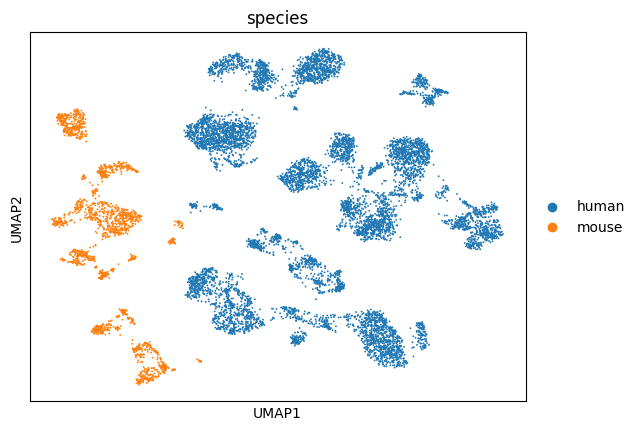

UMAP plot saved to plots/umap_species.png


In [11]:
# Optional: Visualize the optimal transport pairs on UMAP
sc.pp.neighbors(combined_adata, use_rep='X_pca')
sc.tl.umap(combined_adata)

# Visualize UMAP
umap_species_plot_path = os.path.join(plots_dir, "umap_species.png")
fig = sc.pl.umap(combined_adata, color=['species'], return_fig=True, s=7)
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_species_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_species_plot_path}")


/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


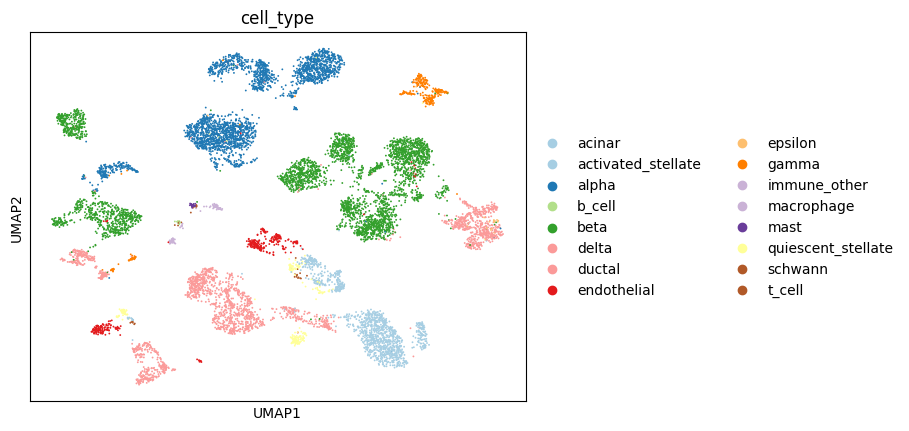

UMAP plot saved to plots/umap_cell_type.png


In [12]:

# Optional: Visualize the optimal transport pairs on UMAP
sc.pp.neighbors(combined_adata, use_rep='X_pca')
sc.tl.umap(combined_adata)

# Visualize UMAP
umap_cell_type_plot_path = os.path.join(plots_dir, "umap_cell_type.png")
fig = sc.pl.umap(combined_adata, color=['cell_type'], return_fig=True, palette="Paired", s=7)
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_cell_type_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_cell_type_plot_path}")

In [13]:
def plot_joint_umap_with_pairs(
    human_mouse_joint_adata,
    num_human_cells,
    paired_indices,
    color_label,
    save_path,
    title,
    cell_type=None,
    adata_human=None,
    adata_mouse=None,
    filter_by_human=True  # if True, shows which mouse cells all human cells map to, else vice versa
):
    """
    Create a joint UMAP of human and mouse AnnData objects and plot the lines connecting paired cells.

    Parameters:
    - human_mouse_adata: AnnData object for human and mouse cells.
    - paired_indices: List of tuples (human_index, mouse_index) of paired cells.
    - color_label: The column in `obs` to color by.
    - save_path: Path to save the plot.
    - cell_type: (Optional) Filter pairs by specific cell type.
    - adata_human: AnnData object for human cells.
    - adata_mouse: AnnData object for mouse cells.
    - filter_by_human: True to filter by human cell type, False to filter by mouse cell type.
    """
    # Ensure the "plots" directory exists
    plots_dir = os.path.join(os.getcwd(), "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    # Construct the full save path
    full_save_path = os.path.join(plots_dir, save_path)
    
    # Ensure UMAP is computed and stored in the AnnData object
    if 'X_umap' not in human_mouse_joint_adata.obsm:
        sc.pp.neighbors(human_mouse_joint_adata)
        sc.tl.umap(human_mouse_joint_adata)
    
    if color_label=='species':
        # Plot the UMAP
        sc.pl.umap(
            human_mouse_joint_adata, 
            color=color_label, 
            show=False, 
            s=7,
            title=title,
        )
    else:
        # Plot the UMAP
        sc.pl.umap(
            human_mouse_joint_adata, 
            color=color_label, 
            show=False, 
            palette="Paired",
            s=7,
            title=title,
        )

    # Extract the UMAP coordinates
    umap_human = human_mouse_joint_adata.obsm['X_umap'][:num_human_cells, :]
    umap_mouse = human_mouse_joint_adata.obsm['X_umap'][num_human_cells:, :]

    # Filter the paired indices based on the specified cell type, if provided
    if cell_type:
        if filter_by_human:
            human_cell_type_mask = adata_human.obs['cell_types'] == cell_type
            filtered_pairs = [
                (human_idx, mouse_idx) for human_idx, mouse_idx in paired_indices
                if human_cell_type_mask[human_idx]
            ]
        else:
            mouse_cell_type_mask = adata_mouse.obs['cell_types'] == cell_type
            filtered_pairs = [
                (human_idx, mouse_idx) for human_idx, mouse_idx in paired_indices
                if mouse_cell_type_mask[mouse_idx]
            ]
    else:
        # Use all pairs if no cell type is specified
        filtered_pairs = paired_indices

    # Plot lines connecting paired human and mouse cells
    for human_idx, mouse_idx in filtered_pairs:
        # Get the UMAP coordinates of the paired human and mouse cells
        human_coord = umap_human[human_idx]
        mouse_coord = umap_mouse[mouse_idx]
        
        # Plot a light gray line connecting the paired cells
        plt.plot([human_coord[0], mouse_coord[0]], 
                 [human_coord[1], mouse_coord[1]], 
                 color='lightgray', linewidth=0.6, alpha=0.2, linestyle="--")

    # Save the plot
    plt.savefig(full_save_path, facecolor="white", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()

    # Print confirmation
    print(f"Plot saved to {full_save_path}")

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


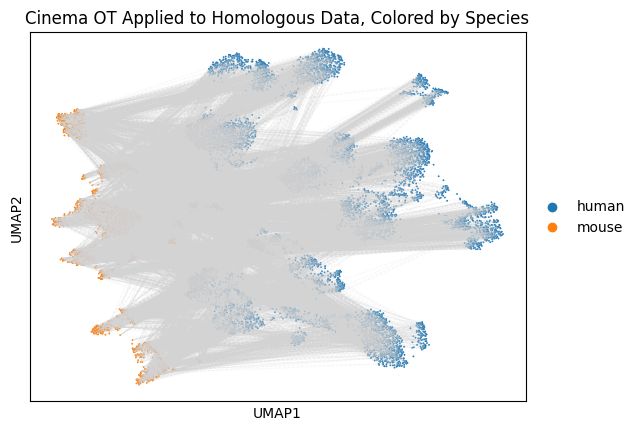

Plot saved to /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Cinema OT on Homology Data/plots/cinema_ot_paired_homologous_data_species.png


In [14]:
color_label='species'
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=combined_adata, 
    num_human_cells=human_adata.shape[0],
    paired_indices=paired_indices, 
    color_label=color_label, 
    save_path="cinema_ot_paired_homologous_data_species.png", 
    title=f"Cinema OT Applied to Homologous Data, Colored by {str.capitalize(color_label)}",
    adata_human=human_adata, 
    adata_mouse=mouse_adata
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


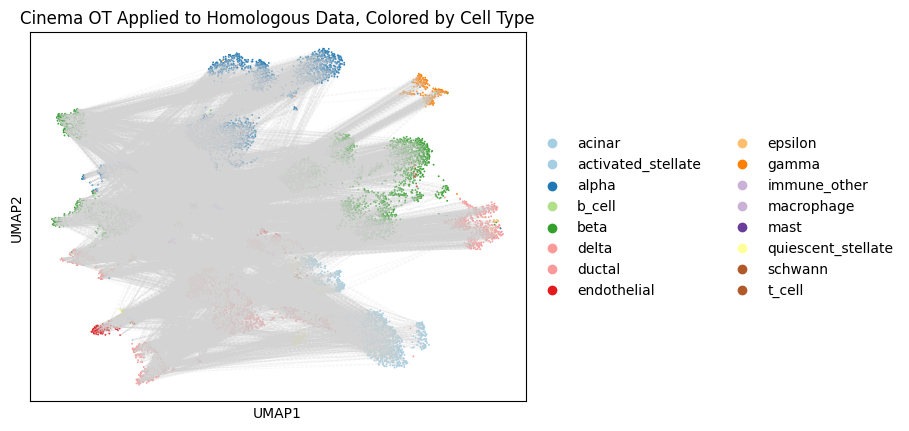

Plot saved to /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Cinema OT on Homology Data/plots/cinema_ot_paired_homologous_data_cell_type.png


In [16]:
color_label='cell_type'
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=combined_adata, 
    num_human_cells=human_adata.shape[0],
    paired_indices=paired_indices, 
    color_label=color_label, 
    save_path="cinema_ot_paired_homologous_data_cell_type.png", 
    title=f"Cinema OT Applied to Homologous Data, Colored by Cell Type",
    adata_human=human_adata, 
    adata_mouse=mouse_adata
)

In [18]:
# Extract true labels
human_labels = [x.lower() for x in human_adata.obs['cell_type'].values]
mouse_labels = [x.lower() for x in mouse_adata.obs['cell_type'].values]

# Create lists of labels based on paired indices
paired_human_labels = [human_labels[p[0]] for p in paired_indices]
paired_mouse_labels = [mouse_labels[p[1]] for p in paired_indices]

# Ensure both label sets are consistent but separated by species
unique_human_labels = np.unique(human_labels)
unique_mouse_labels = np.unique(mouse_labels)
print("Unique human labels:", unique_human_labels)
print("Unique mouse labels:", unique_mouse_labels)

# Combine unique labels for human and mouse separately
all_labels = np.union1d(unique_human_labels, unique_mouse_labels)

Unique human labels: ['acinar' 'activated_stellate' 'alpha' 'beta' 'delta' 'ductal'
 'endothelial' 'epsilon' 'gamma' 'macrophage' 'mast' 'quiescent_stellate'
 'schwann' 't_cell']
Unique mouse labels: ['activated_stellate' 'alpha' 'b_cell' 'beta' 'delta' 'ductal'
 'endothelial' 'gamma' 'immune_other' 'macrophage' 'quiescent_stellate'
 'schwann' 't_cell']


In [19]:
same_cell_type = [x for x in all_labels if x in unique_human_labels and x in unique_mouse_labels]
print("Shared cell types in human and mice:", same_cell_type)

Shared cell types in human and mice: ['activated_stellate', 'alpha', 'beta', 'delta', 'ductal', 'endothelial', 'gamma', 'macrophage', 'quiescent_stellate', 'schwann', 't_cell']


In [20]:
plot_path = "cinema_ot_homologous_data_confusion_matrix"
# Generate confusion matrix with consistent labels
cm = confusion_matrix(paired_human_labels, paired_mouse_labels, labels=all_labels)

# Convert to DataFrame for better visualization
cm_df = DataFrame(cm, index=all_labels, columns=all_labels)

# Compute row and column sums
row_sums = cm_df.sum(axis=1)
col_sums = cm_df.sum(axis=0)

# Filter rows and columns where the sum of values is not equal to 0
non_zero_rows = row_sums != 0
non_zero_cols = col_sums != 0

# Apply the filters to the DataFrame
filtered_cm_df = cm_df.loc[non_zero_rows, non_zero_cols]

# Define file path for the heatmap plot
cm_path = os.path.join(plots_dir, plot_path)

# Create a matplotlib figure and axis
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_cm_df, annot=True, fmt='d', cmap='Greens', linewidths=.4)
plt.title('Confusion Matrix of Human-Mouse Cell Pairs', fontsize=20)
plt.xlabel('Mouse Cell Types', fontsize=15)
plt.ylabel('Human Cell Types', fontsize=15)

# Save the plot using matplotlib
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"Confusion matrix plot saved to {cm_path}")


Confusion matrix plot saved to plots/cinema_ot_homologous_data_confusion_matrix


# Legacy code (no longer in use) below

## Weighted Cinemaot

In [18]:
num_human_cells = 8569
num_mouse_cells = 1886

# Handle cell number imbalances with weight adjustments
human_weight = 1.0 * num_mouse_cells / num_human_cells
mouse_weight = 1.0  # weights can be normalized to sum up to 1

# Extracting species label to adjust weights accordingly
weights = np.where(combined_adata.obs['species'] == 'human', human_weight, mouse_weight)

# Adding weights to combined_adata
combined_adata.obs['weights'] = weights


In [19]:
weights

array([0.22009569, 0.22009569, 0.22009569, ..., 1.        , 1.        ,
       1.        ])

In [20]:
# Run CINEMA-OT
cf_weighted, ot_weighted, de_weighted, r_weighted = co.cinemaot.cinemaot_weighted(
    adata=combined_adata,
    obs_label='species',   # Column indicating species
    ref_label='human',     # Reference species
    expr_label='mouse',    # Experimental species
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:121:

In [21]:
# Display results
print("Confounder (cf) shape:", cf_weighted.shape)
print("Optimal Transport (ot) shape:", ot_weighted.shape)
print("Differential Expression (de) shape:", de_weighted.shape)
print("Weights for expr condition (r):", r_weighted)

Confounder (cf) shape: (10455, 20)
Optimal Transport (ot) shape: (8569, 1007)
Differential Expression (de) shape: (8569, 11366)
Weights for expr condition (r): [0.         0.06176471 0.         ... 0.         0.         0.06176471]


In [22]:
# Extract paired indices based on the optimal transport plan
paired_indices = []
for human_idx in range(ot_weighted.shape[0]):
    if np.sum(ot_weighted[human_idx]) > 0:
        mouse_idx = np.argmax(ot_weighted[human_idx])
        paired_indices.append((human_idx, mouse_idx))

In [23]:
if not np.isnan(ot_weighted).any():
    # Extract paired indices based on the optimal transport plan
    paired_indices = []
    for human_idx in range(ot_weighted.shape[0]):
        if np.sum(ot_weighted[human_idx]) > 0:
            mouse_idx = np.argmax(ot_weighted[human_idx])
            paired_indices.append((human_idx, mouse_idx))

    # Print paired indices
    print("Weighted CinemaOT Optimal Transport Pairs (human_idx, mouse_idx):")
    for human_idx, mouse_idx in paired_indices:
        print(f"Human cell {human_idx} paired with Mouse cell {mouse_idx}")


Weighted CinemaOT Optimal Transport Pairs (human_idx, mouse_idx):
Human cell 0 paired with Mouse cell 932
Human cell 1 paired with Mouse cell 361
Human cell 2 paired with Mouse cell 932
Human cell 3 paired with Mouse cell 839
Human cell 4 paired with Mouse cell 839
Human cell 5 paired with Mouse cell 652
Human cell 6 paired with Mouse cell 170
Human cell 7 paired with Mouse cell 838
Human cell 8 paired with Mouse cell 361
Human cell 9 paired with Mouse cell 932
Human cell 10 paired with Mouse cell 361
Human cell 11 paired with Mouse cell 932
Human cell 12 paired with Mouse cell 124
Human cell 13 paired with Mouse cell 84
Human cell 14 paired with Mouse cell 864
Human cell 15 paired with Mouse cell 1006
Human cell 16 paired with Mouse cell 497
Human cell 17 paired with Mouse cell 1005
Human cell 18 paired with Mouse cell 332
Human cell 19 paired with Mouse cell 122
Human cell 20 paired with Mouse cell 277
Human cell 21 paired with Mouse cell 18
Human cell 22 paired with Mouse cell 332
H

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


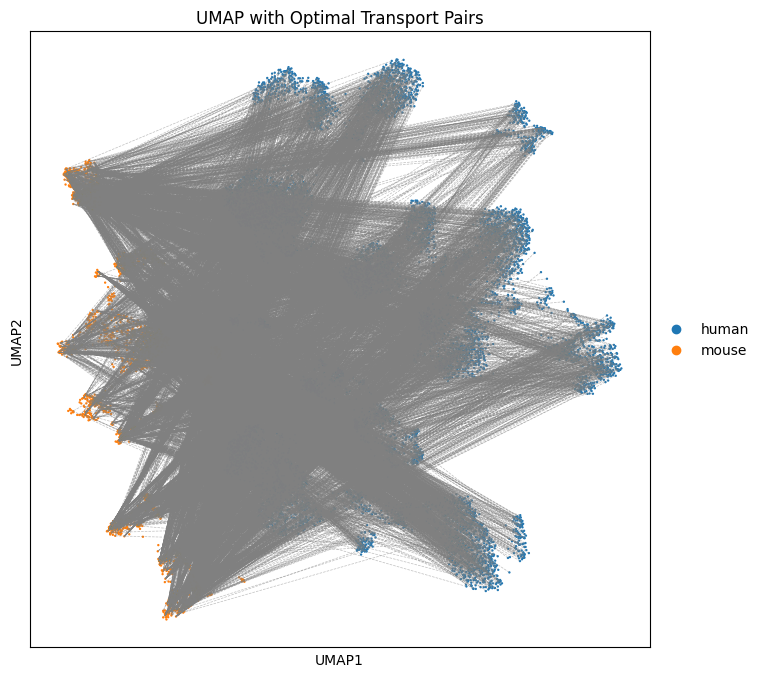

UMAP plot saved to plots/weighted_cinemaot_umap_ot_pairs_species.png


In [24]:
# Optional: Plot optimal transport pairs
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(combined_adata, color=['species'], ax=ax, show=False)
for human_idx in range(ot_weighted.shape[0]):
    if np.sum(ot_weighted[human_idx]) > 0:
        mouse_idx = np.argmax(ot_weighted[human_idx])
        h = combined_adata.obsm['X_umap'][human_idx, :]
        m = combined_adata.obsm['X_umap'][mouse_idx + human_adata.shape[0], :]
        plt.plot([h[0], m[0]], [h[1], m[1]], color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.title('UMAP with Optimal Transport Pairs')
plt.show()

weighted_umap_ot_pair_species_path = os.path.join(plots_dir, "weighted_cinemaot_umap_ot_pairs_species.png")
# Save the plot using matplotlib
fig.savefig(weighted_umap_ot_pair_species_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {weighted_umap_ot_pair_species_path}")

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


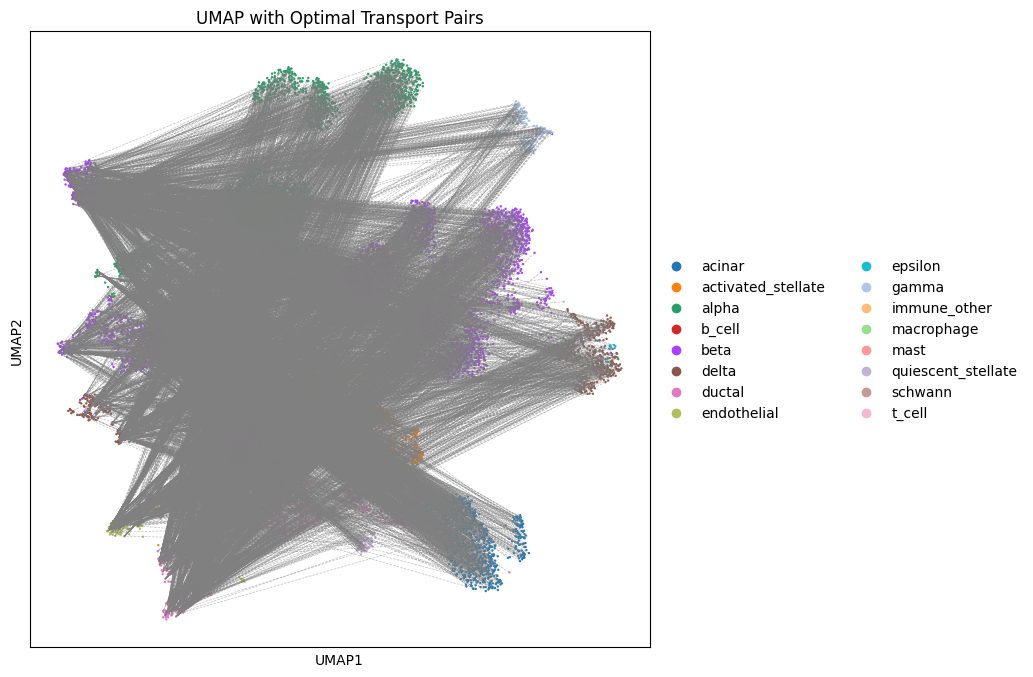

UMAP plot saved to plots/weighted_cinemaot_umap_ot_pairs_cell_type.png


In [25]:
# Optional: Plot optimal transport pairs
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(combined_adata, color=['cell_type'], ax=ax, show=False)
for human_idx in range(ot_weighted.shape[0]):
    if np.sum(ot_weighted[human_idx]) > 0:
        mouse_idx = np.argmax(ot_weighted[human_idx])
        h = combined_adata.obsm['X_umap'][human_idx, :]
        m = combined_adata.obsm['X_umap'][mouse_idx + human_adata.shape[0], :]
        plt.plot([h[0], m[0]], [h[1], m[1]], color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.title('UMAP with Optimal Transport Pairs')
plt.show()

weighted_umap_ot_pair_cell_type_path = os.path.join(plots_dir, "weighted_cinemaot_umap_ot_pairs_cell_type.png")
# Save the plot using matplotlib
fig.savefig(weighted_umap_ot_pair_cell_type_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {weighted_umap_ot_pair_cell_type_path}")

In [26]:
# Generate confusion matrix with consistent labels
cm_weighted = confusion_matrix(paired_human_labels, paired_mouse_labels, labels=all_labels)

# Convert to DataFrame for better visualization
cm_df_weighted = DataFrame(cm_weighted, index=all_labels, columns=all_labels)

# Define file path for the heatmap plot
weighted_confusion_matrix_cinemaot_path = os.path.join(plots_dir, "weighted_cinemaot_confusion_matrix.png")

# Create a matplotlib figure and axis
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df_weighted, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix of Human-Mouse Cell Pairs')
plt.xlabel('Mouse Cell Types')
plt.ylabel('Human Cell Types')

# Save the plot using matplotlib
plt.savefig(weighted_confusion_matrix_cinemaot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"Confusion matrix plot saved to {weighted_confusion_matrix_cinemaot_path}")


Confusion matrix plot saved to plots/weighted_cinemaot_confusion_matrix.png
